<h1 align = "center" >HRV analysis</h1>

## Introduction
The aim of this notebook is to perform the HRV analysis on the data from the BrainLab database. The data is stored as a CSV file. First the data will be loaded and then the HRV analysis will be performed. Data will be loaded using the `pandas` library. HRV analysis will be performed using the `pyhrv` and `neurokit2` libraries. `neurokit2` library is a Python library for biosignal processing. The data will be plotted using the `matplotlib` library.

## Importing the libraries

In [394]:
import neurokit2 as nk 
from pyhrv import frequency_domain as fd 
from pyhrv import time_domain as td
import matplotlib.pyplot as plt 
from pathlib import Path
import pandas as pd
import csv
import os
import csv
import numpy as np

We are interested in the following HRV parameters:

In [369]:
content = [
           'HRV_SDNN',
           'HRV_RMSSD',
           'HRV_MeanNN',
           'HRV_pNN50',
           'HRV_pNN20',
           'HRV_ApEn',
           'HRV_SampEn',
           'HRV_FuzzyEn',
           'HRV_MSEn',
           'HRV_ShanEn'
           ]

freq_content = [
                'HRV_LF',
                'HRV_HF',
                'HRV_TP'
                ]

## Loading the data

In [ ]:
path = '6_BREATHS' # path to the folder with the data
folder_path = Path(path) # path to the folder with the data
csv_files = list(folder_path.glob("*.csv")) # list of all the csv files in the folder
print(csv_files) # printing the list of files

## HRV analysis using ABP signal

In [ ]:
final_df_abp = pd.DataFrame()

for name in csv_files:
    try:
        df = pd.read_csv(name, sep=';')  # loading the data
        df_abp = df['abp_cnap[mmHg]'].apply(lambda x: float(x.replace(',', '.')))  # replacing commas with dots
        name_without_csv = os.path.splitext(os.path.basename(name))[0]  # getting the name of the file without the .csv extension

        processed_signal = nk.ppg_process(df_abp, sampling_rate=200)  # processing the signal
        hrv = nk.hrv(processed_signal[0], sampling_rate=200)  # performing the HRV analysis
        interesting_content = hrv[content]  # selecting the interesting content

        # freq content needs to be calculated separately because of the different sampling rate
        hrv_freq = hrv[freq_content]  # selecting the interesting content

        cleaned_signal = nk.ppg_clean(df_abp, sampling_rate=200)  # cleaning the signal
        r_peaks = nk.ppg_findpeaks(cleaned_signal, sampling_rate=200)['PPG_Peaks']  # finding the R-peaks
        pyhrv_freq = fd.welch_psd(rpeaks=r_peaks, show=False)['fft_abs']  # using pyhrv library to calculate the frequency domain parameters

        merged_df = pd.concat([interesting_content, hrv_freq], axis=1)  # merging the dataframes
        merged_df['file_name'] = name_without_csv  # adding file_name column
        final_df_abp = pd.concat([final_df_abp, merged_df], ignore_index=True)  # concatenate final_df with merged_df

    except Exception as e:
        print(f"Error in file {name} --> {str(e)}")

final_df_abp.to_csv('final_output.csv', index=False)


In [ ]:
print(final_df_abp.to_csv(index = False))

## HRV analysis using ECG signal

In [ ]:
final_df_ecg = pd.DataFrame()
for name in csv_files:
    # here i need to adjust the code to search for the ECG signal in the csv file 
    try:
        df = pd.read_csv(name, sep=';')
        if 'ecg' in df.columns:
            df_ecg = df['ecg']
        elif 'ecg[mV]' in df.columns:
            df_ecg = df['ecg[mV]']
        else:
            print(f"No 'ecg' or 'ecg[mV]' column in file {name}")
            continue
            
        df_ecg = [float(i.replace(',','.')) for i in df_ecg]
        processed_signal = nk.ecg_process(df_ecg, sampling_rate=200)
        hrv = nk.hrv(processed_signal[0], sampling_rate=200)
        name_without_csv = os.path.splitext(name.name)[0]
        interesting_content = hrv[content]
        # print(f"------------{name_without_csv}------------")
        # print(interesting_content)
        
        hrv_freq = hrv[freq_content]
        # print(hrv_freq)
        
        cleaned_signal = nk.ecg_clean(df_ecg, sampling_rate=200)
        r_peaks = nk.ecg_findpeaks(cleaned_signal, sampling_rate=200)['ECG_R_Peaks']
        pyhrv_freq = fd.welch_psd(rpeaks=r_peaks, show=False)['fft_abs']
        # print(pyhrv_freq)
        merged_df = pd.concat([interesting_content, hrv_freq], axis=1)
        merged_df['file_name'] = name_without_csv
        # print(merged_df)
        all_analyse = merged_df.to_csv(index = False)
        final_df_ecg = pd.concat([final_df_ecg, merged_df], ignore_index=True)  # concatenate final_df with merged_df
        
        
    except Exception as e :
        print(f"Error in file {name} --> {str(e)}")

In [ ]:
print(final_df_ecg.to_csv(index = False))

## Data Plotting

In [389]:
final_df = pd.merge(final_df_abp, final_df_ecg, on='file_name', suffixes=('_abp', '_ecg'))

In [391]:
final_df.to_csv('final_output.csv', index=False)

To present plot of data we will use the bland altman plot. The Bland-Altman plot is a graphical method to analyze the differences between two methods of measurement. The plot shows the difference between the two measurements on the y-axis and the average of the two measurements on the x-axis. The plot is used to determine if the two methods are in agreement, or if they disagree in a consistent way.

find matching files

In [392]:
def bland_altman_plot(data1, data2, *args, **kwargs):
    data1 = np.asarray(data1)
    data2 = np.asarray(data2)
    mean = np.mean([data1, data2], axis=0)  # Mean of the data
    diff = data1 - data2  # Difference between data1 and data2
    md = np.mean(diff)  # Mean of the difference
    sd = np.std(diff, axis=0)  # Standard deviation of the difference

    plt.scatter(mean, diff, *args, **kwargs)  # Use mean1 directly as x-values
    plt.axhline(md, color='gray', linestyle='--', label='Mean Difference')  # Mean Difference line
    plt.axhline(md + 1.96 * sd, color='red', linestyle='--', label='+ 1.96 SD')
    plt.axhline(md - 1.96 * sd, color='red', linestyle='--', label='- 1.96 SD')

    # Add legend
    plt.legend()
    plt.xlabel('Mean of the two measurements')
    plt.ylabel('Difference between the two measurements')
    
    plt.text(1.15, 0.5, f'Mean Difference: {md:.2f}\nSD of Difference: {sd:.2f}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
#   code from https://stackoverflo.com/questions/16399279/bland-altman-plot-in-python - edited

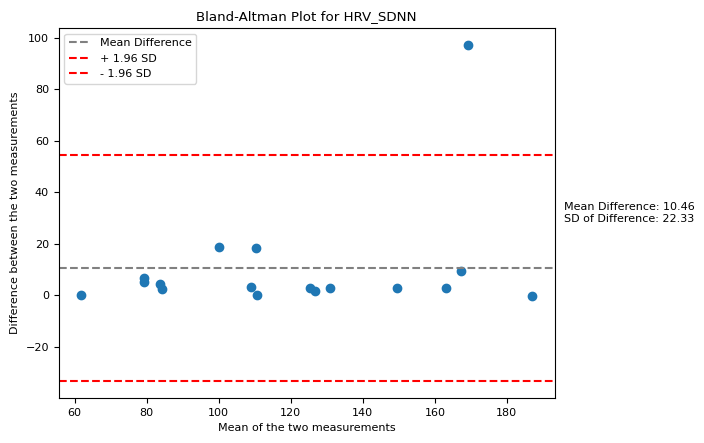

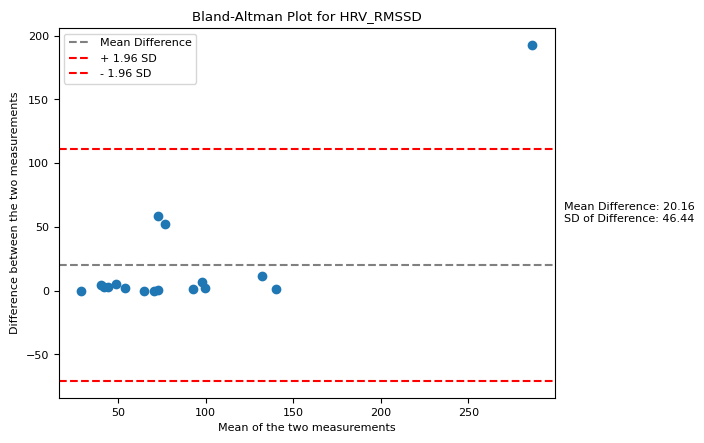

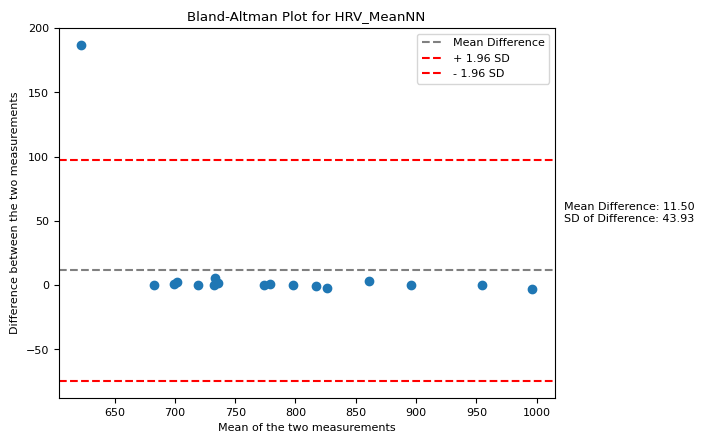

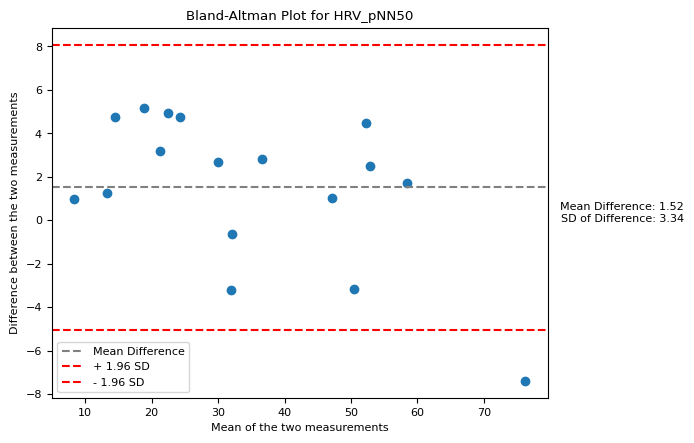

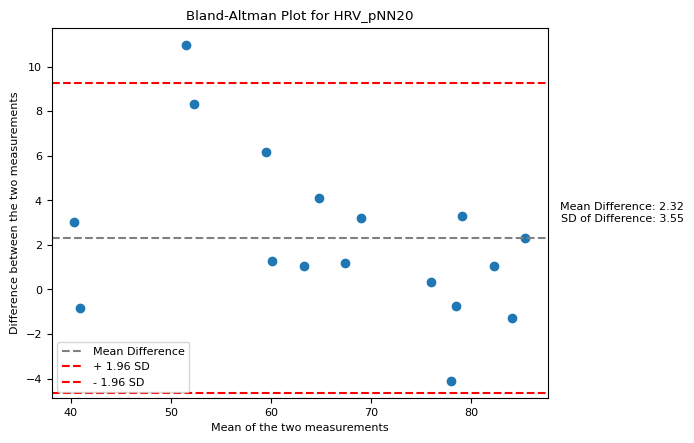

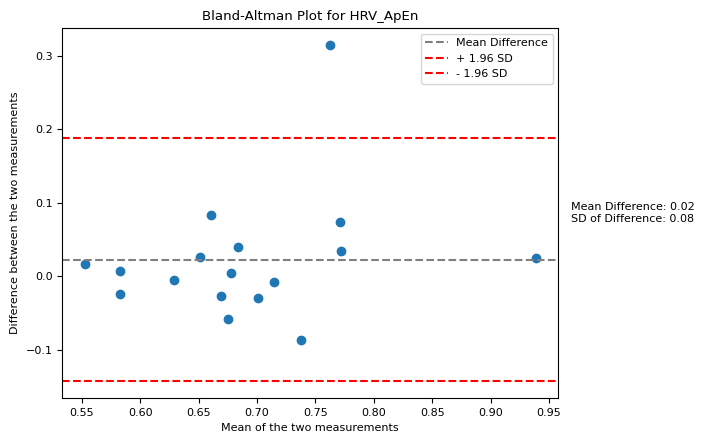

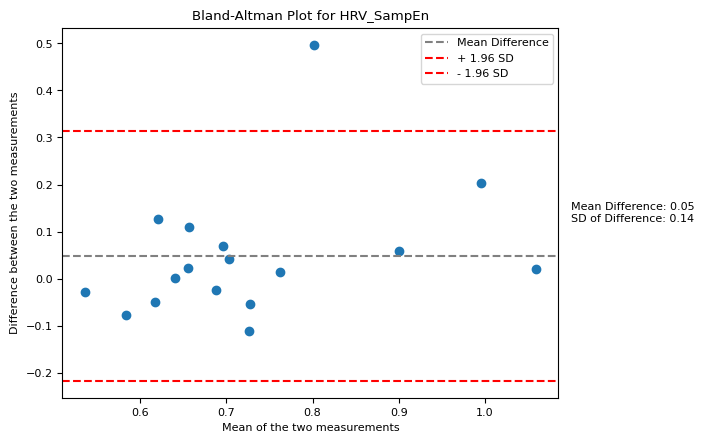

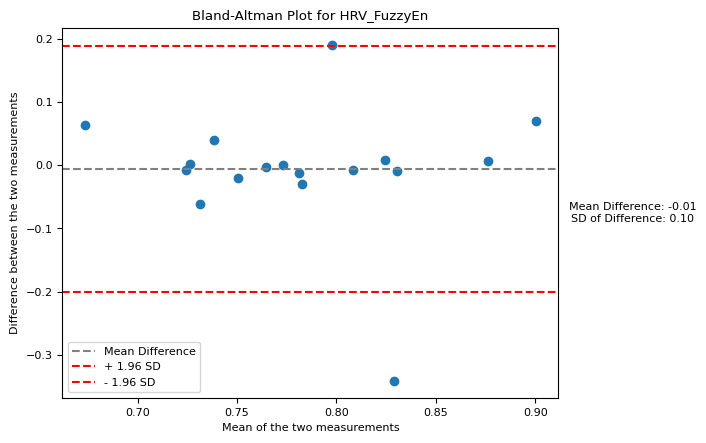

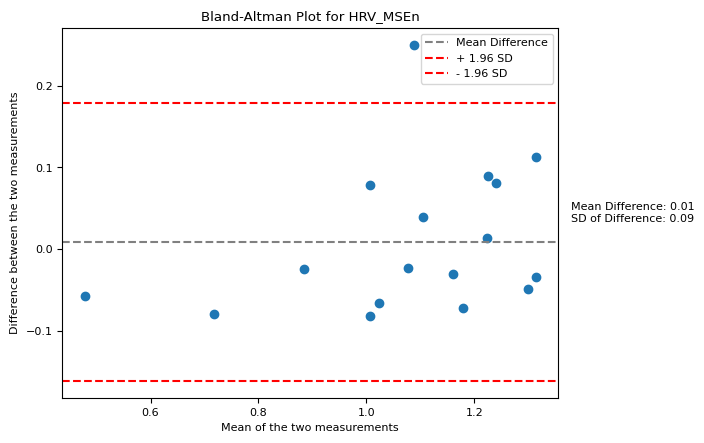

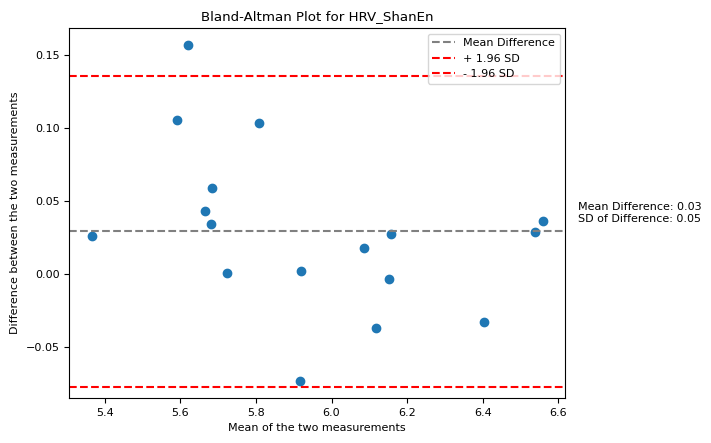

In [395]:
for i in content:
    plt.figure()
    bland_altman_plot(final_df[i + '_abp'], final_df[i + '_ecg'])
    plt.title(f'Bland-Altman Plot for {i}')
    plt.savefig(f'Bland_Altman_Plot_{i}.png')